# 1. 抽取tweets样本做实验

In [23]:
bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-raw.txt', 'rb')
chunkSize = 1000000
chunk = bigfile.readlines(chunkSize)
print len(chunk)
with open("/Users/chengjun/GitHub/cjc2016/data/ows_tweets_sample.txt", 'w') as f:
    for i in chunk:
        f.write(i)

2752


# 2. 清洗错行的情况

In [24]:
with open("/Users/chengjun/GitHub/cjc2016/data/ows_tweets_sample.txt", 'rb') as f:
    lines = f.readlines()

with open("/Users/chengjun/GitHub/cjc2016/data/ows_tweets_sample_clean.txt", 'w') as f:
    block = ''
    blocks = []
    for line in lines:
        block += line.replace('\n', '')
        block_length = len(block.split(','))
        if block_length >= 14:
            blocks.append(block)
            block = ''
    for i in blocks:
        f.write(i + '\n')

# 3. 读取数据、正确分列

In [25]:
with open("/Users/chengjun/GitHub/cjc2016/data/ows_tweets_sample_clean.txt", 'rb') as f:
    chunk = f.readlines()

In [42]:
chunk[:3]

['"Twitter ID",Text,"Profile Image URL",Day,Hour,Minute,"Created At",Geo,"From User","From User ID",Language,"To User","To User ID",Source\n',
 '121813144174727168,"RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE RT !!HELP!!!!",http://a2.twimg.com/profile_images/1539375713/Twitter_normal.jpg,2011-10-06,5,4,"2011-10-06 05:04:51",N;,Anonops_Cop,401240477,en,,0,"&lt;a href=&quot;http://twitter.com/&quot;&gt;web&lt;/a&gt;"\n',
 '121813146137657344,"@jamiekilstein @allisonkilkenny Interesting interview (never aired, wonder why??) by Fox with #ows protester http://t.co/Fte55Kh7",http://a2.twimg.com/profile_images/1574715503/Kate6_normal.jpg,2011-10-06,5,4,"2011-10-06 05:04:51",N;,KittyHybrid,34532053,en,jamiekilstein,2149053,"&lt;a href=&quot;http://twitter.com/&quot;&gt;web&lt;/a&gt;"\n']

In [65]:
import csv

lines = csv.reader((line.replace('\x00','') for line in chunk[1:]), delimiter=',', quotechar='"')

# 4. 统计数量

In [71]:
from collections import defaultdict
data_dict = defaultdict(int)
line_num = 0
lines = csv.reader((line.replace('\x00','') for line in chunk[1:]), delimiter=',', quotechar='"')
for i in lines:
    line_num +=1
    data_dict[i[8]] +=1 #


In [72]:
print line_num

2626


In [93]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体 
matplotlib.rc("savefig", dpi=100)
font = FontProperties(fname=r'/Users/chengjun/github/cjc2016/data/msyh.ttf', size=14) 

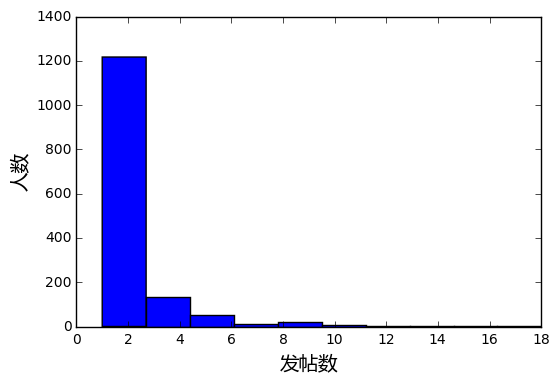

In [104]:
plt.hist(data_dict.values())
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(u'发帖数', fontproperties=font)
plt.ylabel(u'人数', fontproperties=font)
plt.show()

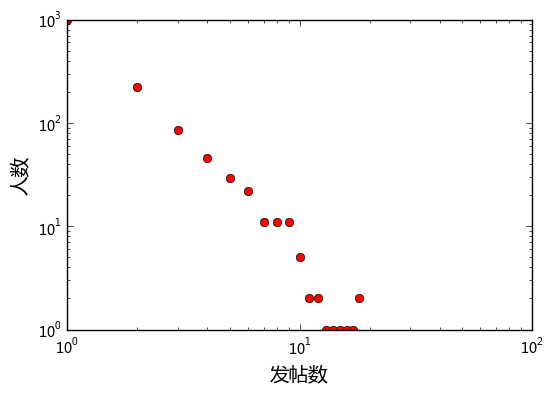

In [106]:
tweet_dict = defaultdict(int)
for i in data_dict.values():
    tweet_dict[i] += 1
 
plt.loglog(tweet_dict.keys(), tweet_dict.values(), 'ro',linewidth=2)  
plt.xlabel(u'发帖数', fontproperties=font)
plt.ylabel(u'人数', fontproperties=font)
plt.show()

In [114]:
import statsmodels.api as sm
from collections import defaultdict
import numpy as np

def powerPlot(data):
    d = sorted(data, reverse = True )
    d_table = defaultdict(int)
    for k in d:
        d_table[k] += 1
    d_value = sorted(d_table)
    d_value = [i+1 for i in d_value]
    d_freq = [d_table[i]+1 for i in d_value]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, 'ro')
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/2,max(d_prob)/5,
             'Beta = ' + str(round(beta,2)) +'\n' + 'R squared = ' + str(round(r2, 2)))
    plt.title('Distribution')
    plt.ylabel('P(K)')
    plt.xlabel('K')
    plt.show()
    

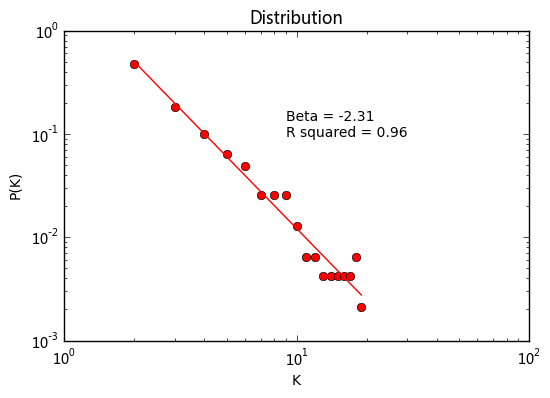

In [115]:
powerPlot(data_dict.values())

# 5. 清洗tweets文本

In [62]:
import re
import twitter_text #pip install twitter-text-py

tweet = '''RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    try:
        rt_user_name = rt_patterns.findall(tweet)[0][1].strip(' @')
        return rt_user_name
    except IndexError, e:
        pass
   

def extract_tweet_text(tweet, at_names, urls):
    for i in at_names:
        tweet = tweet.replace(i, '')
    for j in urls:
        tweet = tweet.replace(j, '')
    marks = ['RT @', '@', '&quot;', '#', '\n', '\t', '  ']
    for k in marks:
        tweet = tweet.replace(k, '')
    return tweet
    
    
ex = twitter_text.Extractor(tweet)
at_names = ex.extract_mentioned_screen_names()
urls = ex.extract_urls()
hashtags = ex.extract_hashtags()
rt_user = extract_rt_user(tweet)
tweet_text = extract_tweet_text(tweet, at_names, urls)

print at_names, urls, hashtags, rt_user,'-------->', tweet_text

[u'AnonKitsu', u'chengjun', u'mili'] [u'http://computational-communication.com', u'http://ccc.nju.edu.cn'] [u'OCCUPYWALLSTREET', u'OWS', u'OCCUPYNY'] AnonKitsu --------> : ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! OCCUPYWALLSTREET OWS OCCUPYNY PLEASE RT !!HELP!!!!


In [63]:
import csv

lines = csv.reader((line.replace('\x00','') for line in chunk[1:]), delimiter=',', quotechar='"')
tweets = [i[1] for i in lines]

In [64]:
for tweet in tweets[:5]:
    ex = twitter_text.Extractor(tweet)
    at_names = ex.extract_mentioned_screen_names()
    urls = ex.extract_urls()
    hashtags = ex.extract_hashtags()
    rt_user = extract_rt_user(tweet)
    tweet_text = extract_tweet_text(tweet, at_names, urls)

    print at_names, urls, hashtags, rt_user, 
    print tweet_text

[u'AnonKitsu'] [] [u'OCCUPYWALLSTREET', u'OWS', u'OCCUPYNY'] AnonKitsu : ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! OCCUPYWALLSTREET OWS OCCUPYNY PLEASE RT !!HELP!!!!
[u'jamiekilstein', u'allisonkilkenny'] [u'http://t.co/Fte55Kh7'] [u'ows'] None Interesting interview (never aired, wonder why??) by Fox with ows protester 
[u'Seductivpancake'] [] [u'ows'] None  Right! Those guys have a victory condition: regime change. ows doesn't seem to have a goal I can figure out.
[u'bembel'] [u'http://j.mp/rhHavq'] [u'OccupyWallStreet', u'OWS'] bembel  Occupy Wall Street als linke Antwort auf die Tea Party?OccupyWallStreet OWS
[] [] [u'ows'] None ows White shirt= Brown shirt.
